# Empirical aDDM Generation

Model independent analysis confirmed that there are good and bad trends within Liu et al.'s (2025) simulated fixation data sampling from the gamma distribution. Following Tavares et al. (2017), we believe that better data can be generated empirically.

### Generating Empirical Data

In [1]:
import os, sys

DDM_dir = os.path.abspath('/Users/bchien37/Desktop/Enkavilab/DDM')
sys.path.append(DDM_dir)

In [2]:
from simulation import get_corrected_empirical_distributions
from ast import literal_eval
import numpy as np
import pandas as pd

df_raw = pd.read_csv('/Users/bchien37/Desktop/Enkavilab/DDM/1ms_trial_data.csv')
df_raw['choice'] = df_raw['choice'].map({'left':0,'right':1})
df_raw['RT'] = df_raw['RT']*1000 # adjustment for RT
df_raw['fixation'] = df_raw['fixation'].apply(literal_eval)

to_drop = pd.read_csv("/Users/bchien37/Desktop/Enkavilab/DDM/dropped_trials.csv").rename(columns={"parcode": "sub_id"})

df = df_raw[
    ~df_raw.set_index(["sub_id", "trial"]).index.isin(
        to_drop.set_index(["sub_id", "trial"]).index
    )
]

num_data, _ = df.shape

value_diffs = np.unique(df['avgWTP_left'] - df['avgWTP_right'])
legend = {
    "left": {1},
    "right": {2},
    "transition": {0}, 
    "blank_fixation": {4}
}
fixation_col = 'fixation'
left_value_col = 'avgWTP_left'
right_value_col = 'avgWTP_right'

empirical_distributions = get_corrected_empirical_distributions(
    df,
    value_diffs=value_diffs,
    legend=legend,
    fixation_col=fixation_col,
    left_value_col=left_value_col,
    right_value_col=right_value_col,
    cutoff=0.9
)

### Translating into efficient-fpt data generation

In [3]:
from efficient_fpt.models import DDModel, piecewise_const_func
from efficient_fpt.utils import get_alternating_addm_mu_array

class aDDModel(DDModel):
    """
    One trial of an attentional drift diffusion model with alternating drift mu1 and mu2.
    """
    def __init__(self, mu1, mu2, sacc_array, flag, sigma, a, b, x0):
        super().__init__(x0)
        # drift parameters
        self.mu1 = mu1
        self.mu2 = mu2
        self.sacc_array = sacc_array
        self.flag = flag # indicates whether the process starts with mu1 (flag=0) or mu2 (flag=1)
        self.d = len(sacc_array) # number of stages
        self.mu_array = get_alternating_addm_mu_array(mu1, mu2, self.d, flag)
        # diffusion parameter
        self.sigma = sigma
        # symmetric linear boundary parameters
        self.a = a
        self.b = b

    def drift_coeff(self, X: float, t: float) -> float:
        return piecewise_const_func(t, self.mu_array, self.sacc_array)

    def diffusion_coeff(self, X: float, t: float) -> float:
        return self.sigma

    @property
    def is_update_vectorizable(self) -> bool:
        return True

    def upper_bdy(self, t: float) -> float:
        return self.a - self.b * t

    def lower_bdy(self, t: float) -> float:
        return -self.a + self.b * t

The key process we want to change is in this section. For now, I won't worry about parallel processing in cython. I've done some preliminary research and realize that pre-generating data is not useful because we have to "dump" data and share it across parallel threads. Perhaps this is why the researchers wanted to generate things internally. 

On the large scale, of course this will not work, but this is an inherent conflict in the applied math pipeline and the cognitive modeling process.

In [4]:
# Defining constants
dt = 0.001
a, b = 2.1, 0.3
eta = 0.7
kappa = 0.5
T = a/b / dt # Bounded by Markov w/p 0.9, E[T] = 2.5, in this case, in ms
x0 = 0
sigma = 1 # As calculated from Eum et al. (2023)

# r1_data = np.zeros(num_data)
# r2_data = np.zeros(num_data)
r1_data = df['avgWTP_left'].to_numpy()
r2_data = df['avgWTP_right'].to_numpy()

seeds = np.random.SeedSequence(123).spawn(num_data)

def simulate_trial(
    n,
    r1_data,
    r2_data,
    empirical_distributions,
    *,
    eta, kappa, sigma, a, b, T, x0, dt, seed
):
    rng = np.random.default_rng(seed)

    r1 = r1_data[n]
    r2 = r2_data[n]

    # --- Generate fixations ---
    fixations = []
    total_dur = 0.0

    latency = rng.choice(empirical_distributions['latencies'])
    fixations.append(latency)
    total_dur += latency

    diff = r1 - r2
    fix_1 = rng.choice(empirical_distributions['fixations'][1][diff])
    fixations.append(fix_1)
    total_dur += fix_1

    while total_dur <= T:
        transition = rng.choice(empirical_distributions['transitions'])
        fixations.append(transition)
        total_dur += transition

        fix_dur = rng.choice(empirical_distributions['fixations'][2][diff])
        fixations.append(fix_dur)
        total_dur += fix_dur

    sacc_array = np.insert(np.cumsum(fixations), 0, 0.0)
    sacc_array = sacc_array[sacc_array < T] * dt

    # --- First fixation side ---
    flag = rng.binomial(1, empirical_distributions['probFixLeftFirst'])

    mu1 = kappa * (r1 - eta * r2)
    mu2 = kappa * (eta * r1 - r2)

    addm = aDDModel(
        mu1=mu1, mu2=mu2,
        sacc_array=sacc_array,
        flag=flag,
        sigma=sigma, a=a, b=b, x0=x0
    )

    decision = addm.simulate_fpt_datum(dt=dt)

    sacc_array = sacc_array[sacc_array < decision[0]]
    d = len(sacc_array)
    mu_array = get_alternating_addm_mu_array(mu1, mu2, d, flag)

    return decision, mu_array, sacc_array, r1, r2, flag

In [5]:
from joblib import Parallel, delayed, cpu_count, dump, load
import time

print("Available jobs:", cpu_count())

start = time.time()

dump(empirical_distributions, "empirical.mmap")
empirical_distributions = load("empirical.mmap", mmap_mode="r")


results = Parallel(n_jobs=-1, backend="loky")(
    delayed(simulate_trial)(
        n,
        r1_data,
        r2_data,
        empirical_distributions,
        eta=eta,
        kappa=kappa,
        sigma=sigma,
        a=a,
        b=b,
        T=T,
        x0=x0,
        dt=dt,
        seed=seeds[n]
    )
    for n in range(num_data)
)

print(f"Elapsed time: {time.time() - start:.3f} seconds")

# Store results
decision_data = np.zeros((num_data, 2))
flag_data = np.zeros(num_data)
mu_data = [None] * num_data
sacc_data = [None] * num_data

for n, (decision, mu_array, sacc_array, r1, r2, flag) in enumerate(results):
    decision_data[n] = decision
    mu_data[n] = mu_array
    sacc_data[n] = sacc_array
    r1_data[n] = r1
    r2_data[n] = r2
    flag_data[n] = flag

Available jobs: 10
Elapsed time: 117.120 seconds


### Model independent analysis

In [6]:
def rasterize_data(
    df: pd.DataFrame,
    subject_col: str,
    trial_col: str,
    seq_col: str = "fixation",
    fill_codes: set = {0, 4},
    start_col: str = "fix_start",
    end_col: str = "fix_end",
    loc_col: str = "fix_location",
    fixnum_col: str | None = None,
    keep_cols: list[str] | None = None,
) -> pd.DataFrame:
    """
    Expand per-(subject, trial) fixation sequences into fixation-level rows.
    Zero-valued segments are treated as transitions and excluded.
    """

    df = df.copy()

    if keep_cols is None:
        keep_cols = [
            c for c in df.columns
            if c not in {subject_col, trial_col, seq_col}
        ]

    rows = []

    for _, row in df.iterrows():
        seq = np.asarray(row[seq_col])

        changes = np.diff(seq, prepend=seq[0])
        starts = np.where(changes != 0)[0]

        fix_num = 0

        for i, start_idx in enumerate(starts):
            loc = seq[start_idx]

            end_idx = (
                starts[i + 1]
                if i + 1 < len(starts)
                else len(seq)
            )

            # Skip transitions
            if loc in fill_codes:
                continue

            data = {
                subject_col: row[subject_col],
                trial_col: row[trial_col],
                start_col: start_idx,
                end_col: end_idx,
                loc_col: loc,
            }

            if fixnum_col is not None:
                data[fixnum_col] = fix_num
                fix_num += 1

            for col in keep_cols:
                data[col] = row[col]

            rows.append(data)

    return pd.DataFrame(rows)

We must define a new addm expand fixation to account for transitions and latencies in the saccade array.

In [7]:
from math import floor, ceil
import numpy as np

def expand_addm_fixations(sacc_data, flag_data, rt_data, dt):
    """
    Parameters
    ----------
    sacc_data : list of 1D np.ndarray
        saccade times per trial (seconds)
    flag_data : 1D np.ndarray
        initial fixation per trial (0/1 or similar)
    rt_data : 1D np.ndarray
        reaction time per trial (seconds)
    dt : float
        timestep size (seconds)

    Encoding
    --------
      0 -> transition
      1 -> fixation with fix_start = 0
      2 -> fixation with fix_start = 1

    Returns
    -------
    array
        Each element is a tuple of fixation locations for one trial
    """
    all_trials = []

    for saccs, start_fix, rt in zip(sacc_data, flag_data, rt_data):

        fix_len = int(floor(rt / dt)) + 1

        # start in transition
        fix = np.zeros(fix_len, dtype=int)

        if len(saccs) > 0:
            switch_idxs = [int(ceil(s / dt)) for s in saccs]

            # fixation identity determined by start_fix
            current_fix = 1 if start_fix == 0 else 2
            state = "fixation"  # first switch enters fixation

            for idx in switch_idxs[1:]:
                if idx <= 0 or idx >= fix_len:
                    continue

                if state == "fixation":
                    fix[idx:] = current_fix
                    state = "transition"
                else:
                    fix[idx:] = 0
                    current_fix = 1 if current_fix == 2 else 2
                    state = "fixation"

        all_trials.append(tuple(fix.tolist()))

    return all_trials

In [8]:
rt_data = decision_data[:, 0].astype(np.float64)
choice_data = decision_data[:, 1].astype(np.int32)
expanded_fixations = expand_addm_fixations(sacc_data, flag_data, rt_data, dt)

efpt_df = pd.DataFrame({
    'sub_id': 'empirical_efpt',
    'trial': range(1, num_data + 1),
    'avgWTP_left': r1_data,
    'avgWTP_right': r2_data,
    'choice': (1 - choice_data) // 2,
    'RT': rt_data * 1000,
    'fixation': expanded_fixations
})

efpt_df.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fixation
0,empirical_efpt,1,1.00,5.0,1,1567.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,empirical_efpt,2,3.00,5.0,1,2310.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,empirical_efpt,3,4.25,1.0,0,1145.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,empirical_efpt,4,3.50,1.0,0,1227.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,empirical_efpt,5,1.50,1.0,0,3182.5,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
efpt_rasterized = rasterize_data(efpt_df, subject_col='sub_id',trial_col='trial',seq_col='fixation')
efpt_rasterized = efpt_rasterized.loc[:, ['sub_id', 'trial', 'avgWTP_left', 'avgWTP_right', 'choice', 'RT', 'fix_start', 'fix_end', 'fix_location']]
efpt_rasterized['fix_dur'] = efpt_rasterized.apply(
    lambda r: r['fix_end'] - r['fix_start'],
    axis=1
)

efpt_rasterized['fix_num'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount() + 1
)

efpt_rasterized['fix_num_rev'] = (
    efpt_rasterized
    .groupby(['sub_id', 'trial'])
    .cumcount(ascending=False) + 1
)
efpt_rasterized.head()

,sub_id,trial,avgWTP_left,avgWTP_right,choice,RT,fix_start,fix_end,fix_location,fix_dur,fix_num,fix_num_rev
0,empirical_efpt,1,1.0,5.0,1,1567.5,326,568,1,242,1,4
1,empirical_efpt,1,1.0,5.0,1,1567.5,578,1143,2,565,2,3
2,empirical_efpt,1,1.0,5.0,1,1567.5,1153,1547,1,394,3,2
3,empirical_efpt,1,1.0,5.0,1,1567.5,1559,1568,2,9,4,1
4,empirical_efpt,2,3.0,5.0,1,2310.5,200,608,2,408,1,5


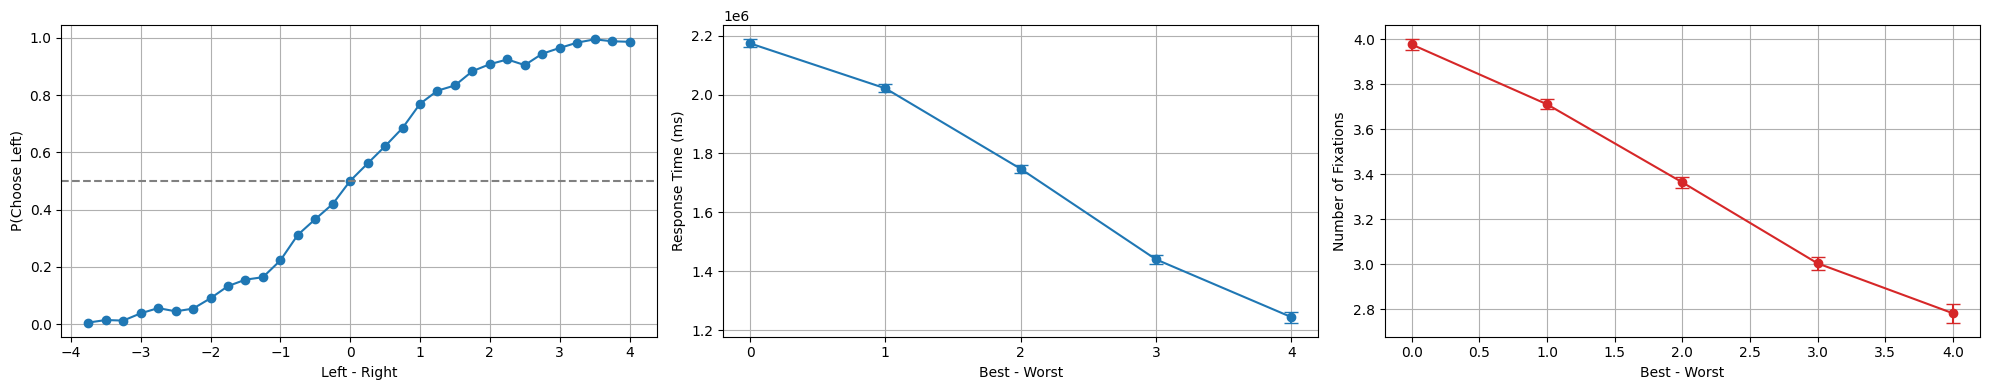

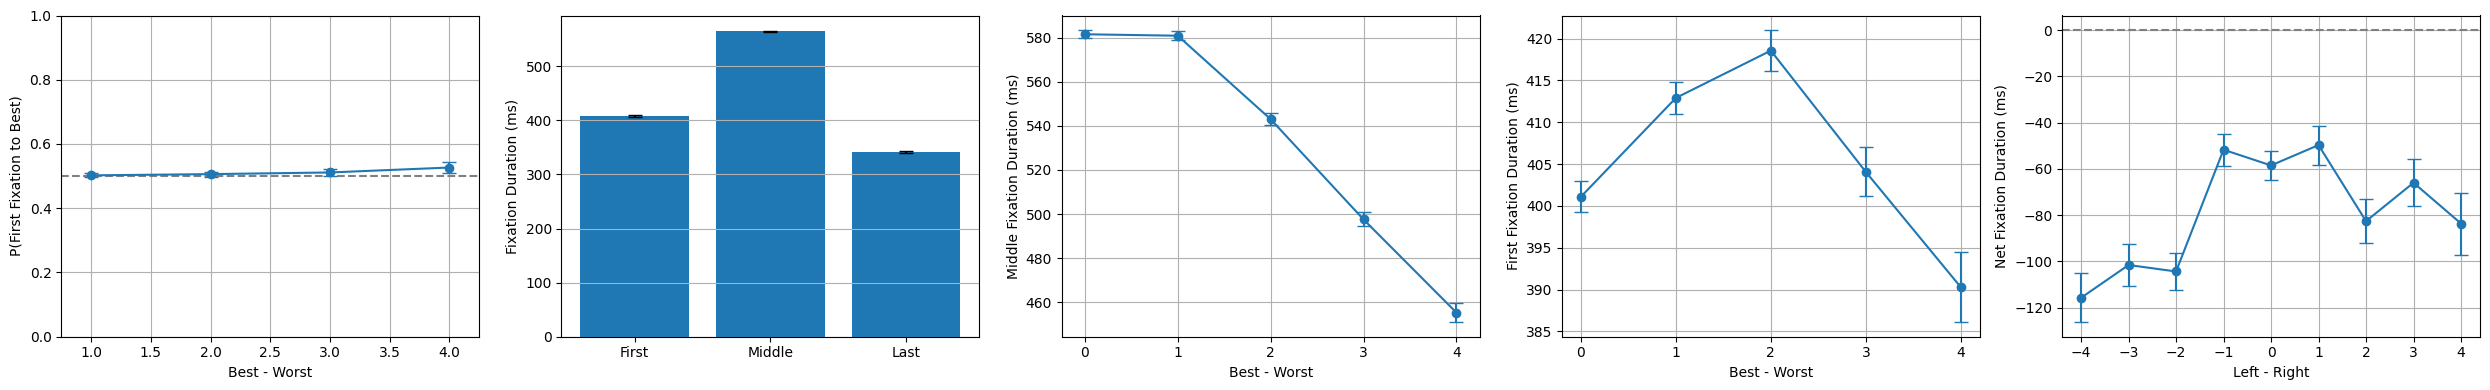

In [10]:
from mfa import plot_basic_psychometrics, plot_fixation_properties

plot_basic_psychometrics(efpt_rasterized)
plot_fixation_properties(efpt_rasterized)

As we can see, there only exists one breach of model independent analysis and that is with the net fixation duration. I bet that if we play around with the parameters, we might find something equitable, but I also propose an alternative. Perhaps the issue is with the stimuli value pairs represented in the data. From `DDM/exploratory_notebooks/grid_search.ipynb`, we know that trials with stimuli values 1 and 1 are overrepresented in the data. This may skew results and mask the fact that net fixation duration given high theta (one of many reasons) is uninformative. Otherwise, the idea of using empirical distributions from a specific experimental design may not be fit. `efficient-fpt` makes it (funnily enough), efficient to model addms under multiple scenarios whereas PyDDM requires a lot of manual definition.